## Stock Project
### Class: NNDL
### Name: Aiden McLean, Lei Wang, Suraj

In [307]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
import requests
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
import pandas as pd
from textblob import TextBlob
import re

In [308]:
# Load Elon Musk's Twitter data
# Load the CSV file containing Elon Musk's tweets
twitter_file_path = 'Elon_tweets_2010_2023.csv'
tweets_df = pd.read_csv(twitter_file_path)

In [309]:
tweets_df.head()

,id,url,time_stamp_UTC,tweet_content,retweet_count,like_count,quote_count,view_count
0,1632525389863034882,https://twitter.com/elonmusk/status/1632525389...,2023-03-05 23:35:58,@kimbal It is inspiring to think that humans d...,2099,45510,155,2203592.0
1,1632525209503928322,https://twitter.com/elonmusk/status/1632525209...,2023-03-05 23:35:15,@chicago_glenn The meme community has high sta...,285,4879,21,114591.0
2,1632524972588695553,https://twitter.com/elonmusk/status/1632524972...,2023-03-05 23:34:18,@ThePrimeagen As an attachment? How many chars...,318,5350,154,2024375.0
3,1632524437227716608,https://twitter.com/elonmusk/status/1632524437...,2023-03-05 23:32:11,Add Fun to the FDA &amp; rename to FFDA,2055,12735,249,9198331.0
4,1632523912893575168,https://twitter.com/elonmusk/status/1632523912...,2023-03-05 23:30:06,@BillyM2k @POTUS What about fun? I say vote fo...,355,5242,44,170313.0


In [310]:
# Rename and clean Twitter data columns
# Keep only the required columns for sentiment analysis
tweets_df = tweets_df[['time_stamp_UTC', 'tweet_content']].copy()

# Rename the columns for better clarity
tweets_df.rename(columns={'time_stamp_UTC': 'date', 'tweet_content': 'text'}, inplace=True)

In [311]:
tweets_df.head()

,date,text
0,2023-03-05 23:35:58,@kimbal It is inspiring to think that humans d...
1,2023-03-05 23:35:15,@chicago_glenn The meme community has high sta...
2,2023-03-05 23:34:18,@ThePrimeagen As an attachment? How many chars...
3,2023-03-05 23:32:11,Add Fun to the FDA &amp; rename to FFDA
4,2023-03-05 23:30:06,@BillyM2k @POTUS What about fun? I say vote fo...


In [312]:
# Standardize the date format to YYYY-MM-DD for alignment with stock data
tweets_df['date'] = pd.to_datetime(tweets_df['date']).dt.date

In [313]:
tweets_df.head()

,date,text
0,2023-03-05,@kimbal It is inspiring to think that humans d...
1,2023-03-05,@chicago_glenn The meme community has high sta...
2,2023-03-05,@ThePrimeagen As an attachment? How many chars...
3,2023-03-05,Add Fun to the FDA &amp; rename to FFDA
4,2023-03-05,@BillyM2k @POTUS What about fun? I say vote fo...


In [314]:
# Text preprocessing for Twitter data
# Remove mentions (e.g., @username) from tweets
tweets_df['text'] = tweets_df['text'].apply(lambda x: re.sub(r'@\w+', '', x))
# Replace HTML entities like &amp; with their actual symbols
tweets_df['text'] = tweets_df['text'].str.replace('&amp;', '&', regex=False)

In [315]:
tweets_df.head()

,date,text
0,2023-03-05,It is inspiring to think that humans did that
1,2023-03-05,The meme community has high standards!
2,2023-03-05,As an attachment? How many chars? We are exte...
3,2023-03-05,Add Fun to the FDA & rename to FFDA
4,2023-03-05,What about fun? I say vote for more fun!


In [316]:
# Sentiment analysis using TextBlob
# Compute polarity and subjectivity scores for each tweet
tweets_df['polarity'] = tweets_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
tweets_df['subjectivity'] = tweets_df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [317]:
# Aggregate sentiment data by date
# Keep the polarity value of the tweet with the maximum absolute polarity value for each day
tweets_df['abs_polarity'] = tweets_df['polarity'].abs()
daily_sentiment = tweets_df.loc[
    tweets_df.groupby('date')['abs_polarity'].idxmax(),
    ['date', 'polarity', 'subjectivity']]

In [318]:
np.random.seed(42)
tf.random.set_seed(42)

In [319]:
# News API key
API_KEY = 'b02dae7aa10849ae9ea5f7beea7dac7a'

# Define the query for Tesla
query = 'Tesla'

# Create the URL for the request
url = f'https://newsapi.org/v2/everything?q={query}&from=2023-11-01&sortBy=popularity&apiKey={API_KEY}'

# Make the request
response = requests.get(url)

# Parse the response
if response.status_code == 200:
    news_data = response.json()
    # Extract the headlines or other relevant information
    headlines = [article['title'] for article in news_data['articles']]
    descriptions = [article['description'] for article in news_data['articles']]

    # Print the first 5 headlines
    for idx, headline in enumerate(headlines[:5]):
        print(f"Headline {idx + 1}: {headline}")
        print(f"Description: {descriptions[idx]}\n")
else:
    print(f"Failed to fetch news: {response.status_code} - {response.text}")

Failed to fetch news: 426 - {"status":"error","code":"parameterInvalid","message":"You are trying to request results too far in the past. Your plan permits you to request articles as far back as 2024-11-03, but you have requested 2023-11-01. You may need to upgrade to a paid plan."}


In [320]:
# Define the ticker for Tesla
stock_symbol = 'TSLA'

# Define the date range for data collection
start_date = '2010-01-01'  # Collecting more historical data
end_date = '2023-10-01'

# Fetch the stock data
def get_stock_data(symbol, start, end):
    stock_data = yf.download(symbol, start=start, end=end)
    stock_data['Symbol'] = symbol
    return stock_data

# Get the data for Tesla
stock_data = get_stock_data(stock_symbol, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [321]:
# Reset index for easier processing
stock_data.reset_index(inplace=True)

# Save the collected data to a CSV file for further processing
stock_data.to_csv('TSLA_stock_data.csv', index=False)

# Display the first few rows of the data
print(stock_data.head())

Price                       Date Adj Close     Close      High       Low  \
Ticker                                TSLA      TSLA      TSLA      TSLA   
0      2010-06-29 00:00:00+00:00  1.592667  1.592667  1.666667  1.169333   
1      2010-06-30 00:00:00+00:00  1.588667  1.588667  2.028000  1.553333   
2      2010-07-01 00:00:00+00:00  1.464000  1.464000  1.728000  1.351333   
3      2010-07-02 00:00:00+00:00  1.280000  1.280000  1.540000  1.247333   
4      2010-07-06 00:00:00+00:00  1.074000  1.074000  1.333333  1.055333   

Price       Open     Volume Symbol  
Ticker      TSLA       TSLA         
0       1.266667  281494500   TSLA  
1       1.719333  257806500   TSLA  
2       1.666667  123282000   TSLA  
3       1.533333   77097000   TSLA  
4       1.333333  103003500   TSLA  


In [322]:
# Standardize the stock price data's date format
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

In [323]:
daily_sentiment.head()

,date,polarity,subjectivity
20726,2010-06-04,0.166667,0.366667
20725,2011-12-01,0.600000,0.733333
20723,2011-12-03,0.450000,0.780000
20721,2011-12-04,0.480000,0.645000
20720,2011-12-21,0.670455,0.684848


In [324]:
print("Stock Data Columns:", stock_data.columns)
print("Daily Sentiment Columns:", daily_sentiment.columns)

Stock Data Columns: MultiIndex([(     'Date',     ''),
            ('Adj Close', 'TSLA'),
            (    'Close', 'TSLA'),
            (     'High', 'TSLA'),
            (      'Low', 'TSLA'),
            (     'Open', 'TSLA'),
            (   'Volume', 'TSLA'),
            (   'Symbol',     '')],
           names=['Price', 'Ticker'])
Daily Sentiment Columns: Index(['date', 'polarity', 'subjectivity'], dtype='object')


In [325]:
# Ensure the 'Date' index level in stock_data is interpreted as datetime
if 'Date' in stock_data.columns.get_level_values(0):
    stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date
elif stock_data.index.name == 'Date' or stock_data.index.names[0] == 'Date':
    stock_data.index = pd.to_datetime(stock_data.index).date

# Check stock_data index levels and names
print("Stock Data Index Names:", stock_data.index.names)

# Get the date range from stock_data
if 'Date' in stock_data.columns:
    stock_date_range = (stock_data['Date'].min(), stock_data['Date'].max())
else:
    stock_date_range = (stock_data.index.min(), stock_data.index.max())

# Ensure the 'date' column in daily_sentiment is in datetime format
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date']).dt.date

# Get the date range from daily_sentiment
sentiment_date_range = (daily_sentiment['date'].min(), daily_sentiment['date'].max())

print("Stock Date Range:", stock_date_range)
print("Sentiment Date Range:", sentiment_date_range)

# Find the overlapping date range
common_start_date = max(stock_date_range[0], sentiment_date_range[0])
common_end_date = min(stock_date_range[1], sentiment_date_range[1])

print("Common Date Range:", common_start_date, "to", common_end_date)

# Filter stock_data to retain rows within the overlapping date range
if 'Date' in stock_data.columns:
    stock_data = stock_data[(stock_data['Date'] >= common_start_date) &
                            (stock_data['Date'] <= common_end_date)]
else:
    stock_data = stock_data.loc[(stock_data.index >= common_start_date) &
                                (stock_data.index <= common_end_date)]

# Filter daily_sentiment to retain rows within the overlapping date range
daily_sentiment = daily_sentiment[(daily_sentiment['date'] >= common_start_date) &
                                  (daily_sentiment['date'] <= common_end_date)]

# Verify the filtered date ranges
if 'Date' in stock_data.columns:
    print("Filtered Stock Data Date Range:",
          (stock_data['Date'].min(), stock_data['Date'].max()))
else:
    print("Filtered Stock Data Date Range:",
          (stock_data.index.min(), stock_data.index.max()))
print("Filtered Daily Sentiment Date Range:",
      (daily_sentiment['date'].min(), daily_sentiment['date'].max()))


Stock Data Index Names: [None]
Stock Date Range: (datetime.date(2010, 6, 29), datetime.date(2023, 9, 29))
Sentiment Date Range: (datetime.date(2010, 6, 4), datetime.date(2023, 3, 5))
Common Date Range: 2010-06-29 to 2023-03-05
Filtered Stock Data Date Range: (datetime.date(2010, 6, 29), datetime.date(2023, 3, 3))
Filtered Daily Sentiment Date Range: (datetime.date(2011, 12, 1), datetime.date(2023, 3, 5))


In [326]:
# Flatten MultiIndex in stock_data for merging
# Combine MultiIndex columns into a single-level structure
stock_data.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in stock_data.columns]

# Rename 'Price_Date' to 'Date' in stock_data if exists
if 'Price_Date' in stock_data.columns:
    stock_data.rename(columns={'Price_Date': 'Date'}, inplace=True)

# Ensure 'daily_sentiment' uses a single-level column structure and rename 'date' to 'Date'
daily_sentiment.rename(columns={'date': 'Date'}, inplace=True)

# Merge stock_data and daily_sentiment on 'Date'
merged_data = pd.merge(
    stock_data,
    daily_sentiment,  # Sentiment data
    on='Date',        # Merge on 'Date' column
    how='left',       # Keep all rows from stock_data
    suffixes=(None, "_dup")  # Use a custom suffix for duplicates
)

# Drop duplicate columns created during the merge
# Identify and remove any columns with the '_dup' suffix
columns_to_drop = [col for col in merged_data.columns if col.endswith("_dup")]
merged_data.drop(columns=columns_to_drop, inplace=True)

# Restore MultiIndex columns in merged_data
# Convert back to MultiIndex for consistency with earlier structure
merged_data.columns = pd.MultiIndex.from_tuples(
    [tuple(col.split('_')) if '_' in col else (col, '') for col in merged_data.columns]
)

# Finalize stock_data structure
stock_data = merged_data

# Verify structure
print(stock_data.tail())

            Date   Adj Close       Close        High         Low        Open  \
                        TSLA        TSLA        TSLA        TSLA        TSLA   
3187  2023-02-27  207.630005  207.630005  209.419998  201.259995  202.029999   
3188  2023-02-28  205.710007  205.710007  211.229996  203.750000  210.589996   
3189  2023-03-01  202.770004  202.770004  207.199997  198.520004  206.210007   
3190  2023-03-02  190.899994  190.899994  193.750000  186.009995  186.740005   
3191  2023-03-03  197.789993  197.789993  200.479996  192.880005  194.800003   

         Volume Symbol polarity subjectivity  
           TSLA                               
3187  161028300   TSLA     1.00         0.75  
3188  153144900   TSLA     0.80         0.75  
3189  156852800   TSLA     1.00         0.30  
3190  181500700   TSLA    -1.00         1.00  
3191  154193300   TSLA     0.25         0.50  


<ipython-input-326-d43a38d62233>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_sentiment.rename(columns={'date': 'Date'}, inplace=True)


In [327]:
# Using len()
num_rows = len(stock_data)

# Using .shape
num_rows = stock_data.shape[0]

print(f"Number of rows in stock_data: {num_rows}")


Number of rows in stock_data: 3192


In [328]:
# Check for null values in the 'polarity' column
if 'polarity' in stock_data.columns.get_level_values(0):
    num_null_polarity = stock_data['polarity'].isnull().sum()
    print(f"Number of null values in 'polarity' column: {num_null_polarity}")
else:
    print("'polarity' column not found in stock_data")

Number of null values in 'polarity' column: 1326


In [329]:
stock_data.to_csv('stock_data.csv', index=False)

In [330]:
# Apply linear interpolation
stock_data['polarity'] = stock_data['polarity'].interpolate(method='linear')

# Fill remaining nulls with forward-fill and backward-fill
stock_data['polarity'].fillna(method='ffill', inplace=True)  # Forward-fill
stock_data['polarity'].fillna(method='bfill', inplace=True)  # Backward-fill

# Verify nulls are resolved
print(f"Remaining null values in 'polarity': {stock_data['polarity'].isnull().sum()}")

Remaining null values in 'polarity': 361


<ipython-input-330-24b9ef5ed514>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data['polarity'].fillna(method='ffill', inplace=True)  # Forward-fill
<ipython-input-330-24b9ef5ed514>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['polarity'].fillna(method='ffill', inplace=True)  # Forward-fill
<ipython-input-330-24b9ef5ed514>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data['polarity'].fillna(method='bfill', inplace=True)  # Backward-fill
<ipython-input-330-24b9ef5ed514>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

In [331]:
# Drop the date before 2011-12-01 due to Musk's tweets are not active before that date.
from datetime import datetime

# Convert the comparison date to datetime.date
comparison_date = datetime.strptime('2011-12-01', '%Y-%m-%d').date()

# Filter the stock_data based on the comparison date
stock_data = stock_data[stock_data['Date'] >= comparison_date]

# Verify the result
print(f"Data after filtering: {stock_data.shape}")

Data after filtering: (2831, 10)


In [332]:
stock_data['polarity'].isnull().sum()

0

In [333]:
# Display the merged data
stock_data.tail(1000)

,Date,Adj Close,Close,High,Low,Open,Volume,Symbol,polarity,subjectivity
,,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA,,,
2192,2019-03-15,18.362000,18.362000,18.914667,18.293333,18.900667,221782500,TSLA,0.312500,0.25
2193,2019-03-18,17.966000,17.966000,18.536667,17.820000,18.400000,154215000,TSLA,0.208333,NaN
2194,2019-03-19,17.831333,17.831333,18.219999,17.563999,17.833332,177009000,TSLA,0.104167,NaN
2195,2019-03-20,18.240000,18.240000,18.331333,17.753332,17.979334,103623000,TSLA,0.000000,0.00
2196,2019-03-21,18.268000,18.268000,18.430000,17.896667,18.173332,89206500,TSLA,1.000000,0.30
...,...,...,...,...,...,...,...,...,...,...
3187,2023-02-27,207.630005,207.630005,209.419998,201.259995,202.029999,161028300,TSLA,1.000000,0.75
3188,2023-02-28,205.710007,205.710007,211.229996,203.750000,210.589996,153144900,TSLA,0.800000,0.75
3189,2023-03-01,202.770004,202.770004,207.199997,198.520004,206.210007,156852800,TSLA,1.000000,0.30


In [334]:
# Calculate Moving Averages (7, 50, 200 days)
stock_data['MA_7'] = stock_data['Close'].rolling(window=7).mean()
stock_data['MA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['MA_200'] = stock_data['Close'].rolling(window=200).mean()

<ipython-input-334-24c6cbe54657>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['MA_7'] = stock_data['Close'].rolling(window=7).mean()
<ipython-input-334-24c6cbe54657>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['MA_50'] = stock_data['Close'].rolling(window=50).mean()
<ipython-input-334-24c6cbe54657>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [335]:
# Calculate Relative Strength Index (RSI) with a period of 14
delta = stock_data['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

average_gain = gain.rolling(window=14).mean()
average_loss = loss.rolling(window=14).mean()

rs = average_gain / average_loss
stock_data['RSI'] = 100 - (100 / (1 + rs))

<ipython-input-335-af1bd34d2d31>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['RSI'] = 100 - (100 / (1 + rs))


In [336]:
# Calculate Bollinger Bands (20-day SMA with 2 standard deviations)
stock_data['BB_middle'] = stock_data['Close'].rolling(window=20).mean()
stock_data['BB_std'] = stock_data['Close'].rolling(window=20).std()

stock_data['BB_upper'] = stock_data['BB_middle'] + (2 * stock_data['BB_std'])
stock_data['BB_lower'] = stock_data['BB_middle'] - (2 * stock_data['BB_std'])

<ipython-input-336-7e64003ac22e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['BB_middle'] = stock_data['Close'].rolling(window=20).mean()
<ipython-input-336-7e64003ac22e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['BB_std'] = stock_data['Close'].rolling(window=20).std()
<ipython-input-336-7e64003ac22e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [337]:
# Calculate MACD and Signal Line
stock_data['EMA_12'] = stock_data['Close'].ewm(span=12, adjust=False).mean()
stock_data['EMA_26'] = stock_data['Close'].ewm(span=26, adjust=False).mean()

stock_data['MACD'] = stock_data['EMA_12'] - stock_data['EMA_26']
stock_data['MACD_signal'] = stock_data['MACD'].ewm(span=9, adjust=False).mean()

<ipython-input-337-10c59ce32425>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['EMA_12'] = stock_data['Close'].ewm(span=12, adjust=False).mean()
<ipython-input-337-10c59ce32425>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['EMA_26'] = stock_data['Close'].ewm(span=26, adjust=False).mean()
<ipython-input-337-10c59ce32425>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [338]:
# Calculate On-Balance Volume (OBV)
stock_data['OBV'] = (stock_data['Volume'] * ((stock_data['Close'] > stock_data['Close'].shift(1)) * 2 - 1)).cumsum()

<ipython-input-338-31123e3dbb6f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['OBV'] = (stock_data['Volume'] * ((stock_data['Close'] > stock_data['Close'].shift(1)) * 2 - 1)).cumsum()


In [339]:
# Calculate Average True Range (ATR)
stock_data['High_Low'] = stock_data['High'] - stock_data['Low']
stock_data['High_Close'] = abs(stock_data['High'] - stock_data['Close'].shift())
stock_data['Low_Close'] = abs(stock_data['Low'] - stock_data['Close'].shift())

stock_data['True_Range'] = stock_data[['High_Low', 'High_Close', 'Low_Close']].max(axis=1)
stock_data['ATR'] = stock_data['True_Range'].rolling(window=14).mean()

# Drop intermediate columns used for ATR calculation
stock_data.drop(columns=['High_Low', 'High_Close', 'Low_Close', 'True_Range'], inplace=True)

<ipython-input-339-5179bb54cc29>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['High_Low'] = stock_data['High'] - stock_data['Low']
<ipython-input-339-5179bb54cc29>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['High_Close'] = abs(stock_data['High'] - stock_data['Close'].shift())
<ipython-input-339-5179bb54cc29>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [340]:
# Data Preprocessing

# Print out the number of missing values before fixing them
print("Missing values before handling:")
print(stock_data.isnull().sum())

# Handling missing data using different methods
# 1. Forward fill to handle initial NaNs created by rolling operations
stock_data.fillna(method='ffill', inplace=True)

# 2. Backward fill to handle any remaining NaNs
stock_data.fillna(method='bfill', inplace=True)

# After handling missing values, print out the number of missing values again to ensure all NaNs are addressed
print("\nMissing values after handling:")
print(stock_data.isnull().sum())

# Select relevant features (including new ones)
features = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'MA_7', 'MA_50', 'MA_200',  # Moving Averages
    'RSI',                       # Relative Strength Index
    'BB_upper', 'BB_middle', 'BB_lower',  # Bollinger Bands
    'MACD', 'MACD_signal',       # Moving Average Convergence Divergence
    'OBV',                       # On-Balance Volume
    'ATR'                        # Average True Range
]

# Step 1: Handle missing values in stock_data
print("Missing values before handling:")
print(stock_data[features].isnull().sum())

# Fill NaN in all features with forward/backward fill or zero
stock_data[features] = stock_data[features].fillna(method='ffill').fillna(method='bfill').fillna(0)

# Verify missing values after handling
print("Missing values after handling:")
print(stock_data[features].isnull().sum())

# Step 2: Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data[features])

print(f"Scaled data shape: {scaled_data.shape}")

# Step 3: Create sequences for LSTM
lookback_period = 60
X_train, y_train = create_sequences(train_data, lookback_period)
X_test, y_test = create_sequences(test_data, lookback_period)

# Check for NaN or Inf in X_train
X_train = np.nan_to_num(X_train, nan=0.0)  # Replace NaN with 0
print(f"NaN in X_train: {np.isnan(X_train).sum()}")

# Verify y_train range
print(f"y_train range: min={y_train.min()}, max={y_train.max()}")


# Normalize the dataset using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data[features])

# Check the shape of the normalized data to ensure it's correct
print(f"\nShape of normalized data: {scaled_data.shape}")

<ipython-input-340-33944c17f0af>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='ffill', inplace=True)
<ipython-input-340-33944c17f0af>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data.fillna(method='ffill', inplace=True)
<ipython-input-340-33944c17f0af>:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='bfill', inplace=True)
<ipython-input-340-33944c17f0af>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Missing values before handling:
Date                    0
Adj Close     TSLA      0
Close         TSLA      0
High          TSLA      0
Low           TSLA      0
Open          TSLA      0
Volume        TSLA      0
Symbol                  0
polarity                0
subjectivity          965
MA_7                    6
MA_50                  49
MA_200                199
RSI                    13
BB_middle              19
BB_std                 19
BB_upper               19
BB_lower               19
EMA_12                  0
EMA_26                  0
MACD                    0
MACD_signal             0
OBV                     0
ATR                    13
dtype: int64

Missing values after handling:
Date                  0
Adj Close     TSLA    0
Close         TSLA    0
High          TSLA    0
Low           TSLA    0
Open          TSLA    0
Volume        TSLA    0
Symbol                0
polarity              0
subjectivity          0
MA_7                  0
MA_50                 0
MA_200     

# Experiments Conducted
The following experiments have been conducted:
1. **Single Layer LSTM Model**: Initial model training to understand baseline performance.
2. **Stacked LSTM Model without Regularization**: Experimented with a deeper model.
3. **Stacked LSTM Model with Regularization**: Experimented with a deeper model and added L2 regularization to control overfitting.
4. **Bidirectional LSTM Model**: Tested a Bidirectional LSTM to improve the model's understanding of time dependencies.
5. **Lookback Period Tuning**: Tested different lookback periods (e.g., 15, 30, 60 days) to find the optimal number of previous days for better prediction.
6. **Hyperparameter Tuning**: Adjustments in learning rate, dropout rate, and batch size were also explored.

The results of each experiment are summarized in the subsequent plots and discussions.


In [341]:
# Define train and test datasets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Define lookback period
lookback_period = 60  # Using 60 days of historical data to predict the next day's price

# Prepare the input data for LSTM
def create_sequences(data, lookback_period):
    X, y = [], []
    for i in range(lookback_period, len(data)):
        X.append(data[i-lookback_period:i])
        y.append(data[i, 3])  # Assuming Close price is at index 3
    return np.array(X), np.array(y)

# Create sequences for LSTM
X_train, y_train = create_sequences(train_data, lookback_period)
X_test, y_test = create_sequences(test_data, lookback_period)

# Verify the shapes of the created sequences
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Build LSTM model
model_1 = Sequential()
model_1.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model_1.add(Dropout(0.2))
model_1.add(Dense(1))

# Compile the model
model_1.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_1 = model_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=64)

# Evaluate the model
train_loss_1 = model_1.evaluate(X_train, y_train, verbose=0)
test_loss_1 = model_1.evaluate(X_test, y_test, verbose=0)
print(f"Single Layer LSTM - Train Loss: {train_loss_1:.4f}, Test Loss: {test_loss_1:.4f}")

X_train shape: (2204, 60, 16), y_train shape: (2204,)
X_test shape: (507, 60, 16), y_test shape: (507,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0175 - val_loss: 0.0384
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0021 - val_loss: 0.0294
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0016 - val_loss: 0.0207
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0011 - val_loss: 0.0194
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 8.3902e-04 - val_loss: 0.0083
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 8.8990e-04 - val_loss: 0.0116
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 6.7560e-04 - val_loss: 0.0124
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 5.3347e-04 - val_loss: 0.0096
Epoch 9/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 4.6223e-04 - val_loss: 0.0097
Epoch 10/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 3.9756e-04 - val_loss: 0.0100
Epoch 11/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 3.3504e-04 - val_loss: 0.0136
Epoch 12/30
35/35 ━━━━━━━━━━━━━━━━━

In [342]:
print(f"NaN in y_test: {np.isnan(y_test).sum()}")
print(f"NaN in y_pred: {np.isnan(y_pred).sum()}")


NaN in y_test: 0
NaN in y_pred: 507


In [343]:
print("Training Loss:", history_1.history['loss'])
print("Validation Loss:", history_1.history['val_loss'])


Training Loss: [0.008157304488122463, 0.0018845143495127559, 0.0013278366532176733, 0.0009664373937994242, 0.0008240960887633264, 0.0007671411731280386, 0.0006200846983119845, 0.0005035774665884674, 0.000451379717560485, 0.000379148026695475, 0.0003610150015447289, 0.0003580701304599643, 0.0002772232692223042, 0.0002764595265034586, 0.0002586621849332005, 0.000240592475165613, 0.0002091554633807391, 0.00020445357949938625, 0.00023594217782374471, 0.0002092122012982145, 0.0001908257108880207, 0.00017083298007491976, 0.00017377860785927624, 0.00016478370525874197, 0.00016397643776144832, 0.0001460526545997709, 0.0001423880603397265, 0.0001423825160600245, 0.00014217464195098728, 0.00013590989692602307]
Validation Loss: [0.03836942836642265, 0.02935349941253662, 0.020747199654579163, 0.01937069557607174, 0.008263206109404564, 0.011556549929082394, 0.012408294714987278, 0.009616072289645672, 0.009731398895382881, 0.009956364519894123, 0.013552750460803509, 0.009185131639242172, 0.011974008

In [344]:
print(f"NaN in X_train: {np.isnan(X_train).sum()}")
print(f"NaN in y_train: {np.isnan(y_train).sum()}")
print(f"Inf in X_train: {np.isinf(X_train).sum()}")
print(f"Inf in y_train: {np.isinf(y_train).sum()}")
print(f"X_train range: {X_train.min()} to {X_train.max()}")
print(f"y_train range: {y_train.min()} to {y_train.max()}")


NaN in X_train: 0
NaN in y_train: 0
Inf in X_train: 0
Inf in y_train: 0
X_train range: 0.0 to 1.0000000000000002
y_train range: 0.0005402537485107153 to 0.4743143015467661


In [345]:
print(f"NaN in stock_data: {stock_data.isnull().sum().sum()}")


NaN in stock_data: 0


In [346]:
stock_data

,Date,Adj Close,Close,High,Low,Open,Volume,Symbol,polarity,subjectivity,...,BB_middle,BB_std,BB_upper,BB_lower,EMA_12,EMA_26,MACD,MACD_signal,OBV,ATR
,,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA,,,,...,,,,,,,,,,
361,2011-12-01,2.173333,2.173333,2.266000,2.132000,2.171333,15453000,TSLA,0.600000,0.733333,...,2.003400,0.167161,2.337722,1.669078,2.173333,2.173333,0.000000,0.000000,-15453000,0.100191
362,2011-12-02,2.220000,2.220000,2.246000,2.160000,2.188667,12042000,TSLA,0.605032,0.733333,...,2.003400,0.167161,2.337722,1.669078,2.180512,2.176790,0.003723,0.000745,-3411000,0.100191
363,2011-12-05,2.294667,2.294667,2.333333,2.228667,2.235333,17401500,TSLA,0.610065,0.733333,...,2.003400,0.167161,2.337722,1.669078,2.198075,2.185521,0.012553,0.003106,13990500,0.100191
364,2011-12-06,2.324667,2.324667,2.332000,2.268667,2.280000,14277000,TSLA,0.615097,0.733333,...,2.003400,0.167161,2.337722,1.669078,2.217550,2.195828,0.021722,0.006829,28267500,0.100191
365,2011-12-07,2.279333,2.279333,2.326000,2.253333,2.308667,10114500,TSLA,0.620130,0.733333,...,2.003400,0.167161,2.337722,1.669078,2.227055,2.202014,0.025041,0.010472,18153000,0.100191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3187,2023-02-27,207.630005,207.630005,209.419998,201.259995,202.029999,161028300,TSLA,1.000000,0.750000,...,196.495000,12.007316,220.509633,172.480368,199.559822,187.004101,12.555722,14.074105,18539726500,11.575716
3188,2023-02-28,205.710007,205.710007,211.229996,203.750000,210.589996,153144900,TSLA,0.800000,0.750000,...,198.447501,9.888541,218.224582,178.670420,200.506005,188.389723,12.116281,13.682540,18386581600,11.542145
3189,2023-03-01,202.770004,202.770004,207.199997,198.520004,206.210007,156852800,TSLA,1.000000,0.300000,...,199.925001,7.935525,215.796051,184.053951,200.854312,189.454929,11.399383,13.225909,18229728800,11.541430


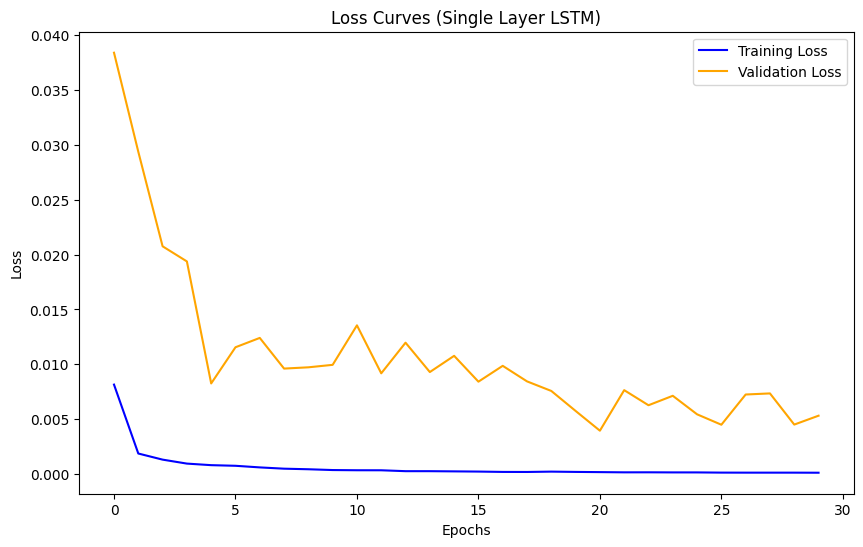

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


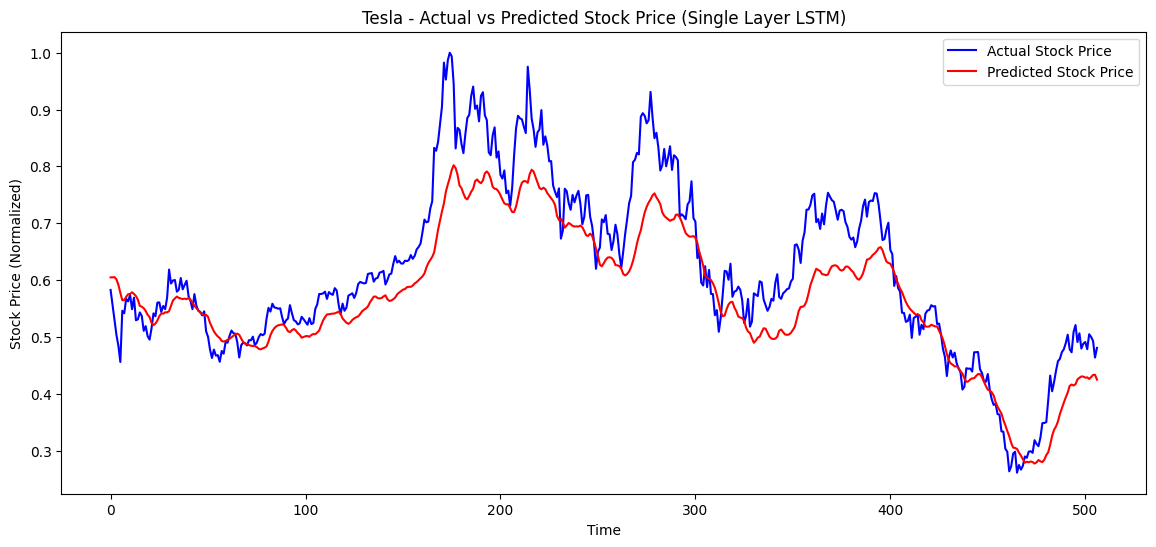

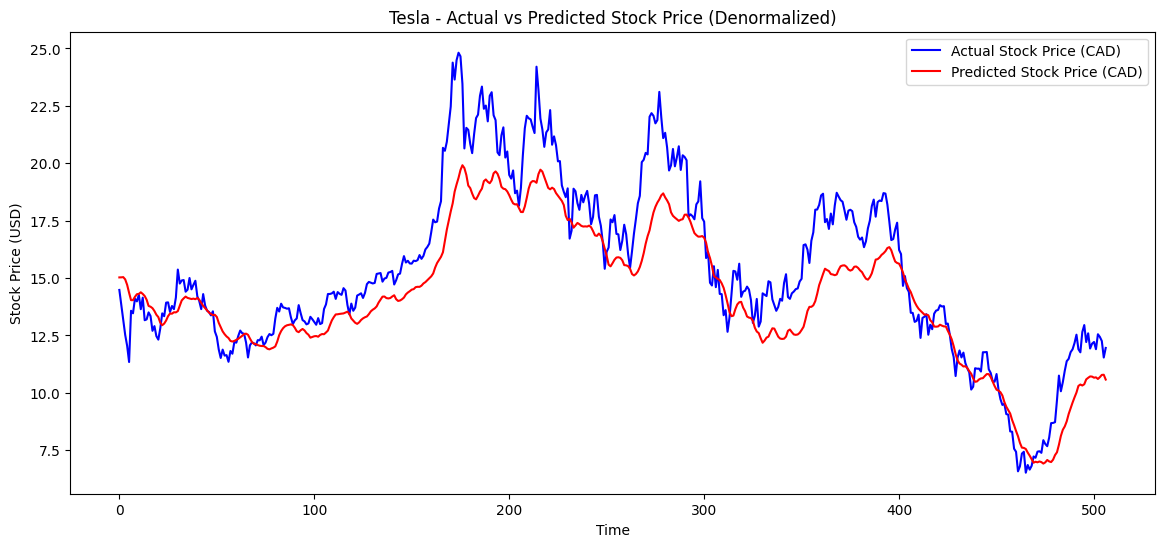

Root Mean Squared Error (RMSE): 1.81 USD
Mean Absolute Error (MAE): 1.40 USD


In [347]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history_1.history['loss'], label='Training Loss', color='blue')
plt.plot(history_1.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves (Single Layer LSTM)')
plt.legend()
plt.show()

# Make predictions on the test dataset
y_pred = model_1.predict(X_test)

# Plot the actual vs predicted stock prices (normalized)
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual Stock Price', color='blue')
plt.plot(y_pred, label='Predicted Stock Price', color='red')
plt.xlabel('Time')
plt.ylabel('Stock Price (Normalized)')
plt.title('Tesla - Actual vs Predicted Stock Price (Single Layer LSTM)')
plt.legend()
plt.show()

# Denormalize the predictions and actual values to compare on the original scale
y_test_denorm = scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], scaled_data.shape[1]-1)), y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_denorm = scaler.inverse_transform(np.concatenate((np.zeros((y_pred.shape[0], scaled_data.shape[1]-1)), y_pred.reshape(-1, 1)), axis=1))[:, -1]

# Plot the actual vs predicted stock prices (denormalized)
plt.figure(figsize=(14, 6))
plt.plot(y_test_denorm, label='Actual Stock Price (CAD)', color='blue')
plt.plot(y_pred_denorm, label='Predicted Stock Price (CAD)', color='red')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.title('Tesla - Actual vs Predicted Stock Price (Denormalized)')
plt.legend()
plt.show()

# Calculate and print RMSE and MAE for the model
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test_denorm, y_pred_denorm))
mae = mean_absolute_error(y_test_denorm, y_pred_denorm)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f} USD")
print(f"Mean Absolute Error (MAE): {mae:.2f} USD")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


<ipython-input-348-ed94afebace5>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[3] = predicted_price


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


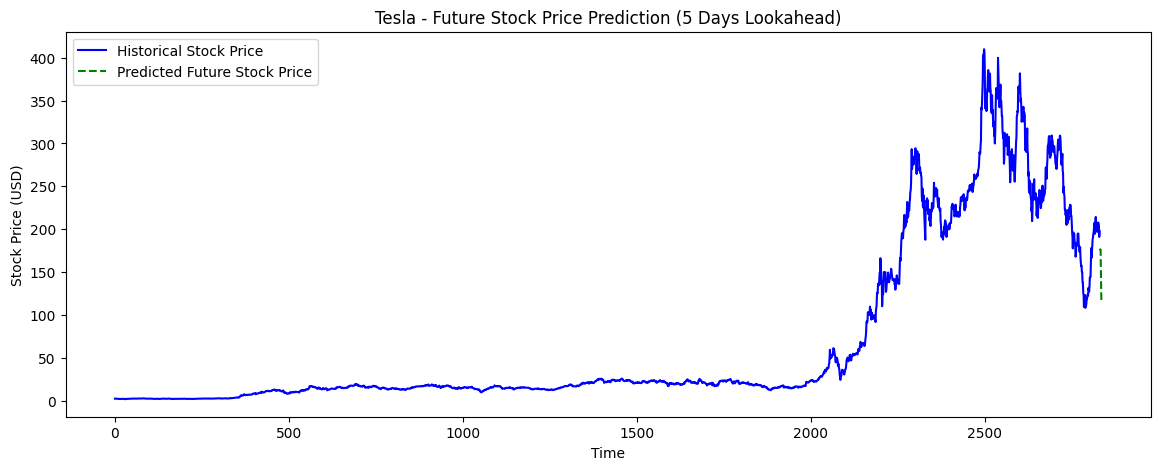

In [348]:
# Define the function for future predictions using a stabilized approach
def predict_future_prices_stabilized(model, data, lookback, n_predictions, true_data_fraction=0.5):
    # Get the last 'lookback' number of days from the scaled dataset
    input_seq = data[-lookback:]
    predicted_prices = []

    # Predict 'n_predictions' into the future
    for i in range(n_predictions):
        # Reshape the input sequence for prediction
        input_seq_reshaped = input_seq.reshape((1, lookback, data.shape[1]))
        predicted_price = model.predict(input_seq_reshaped)

        # Append the predicted price to the list
        predicted_prices.append(predicted_price[0][0])

        # Create a new row to append to the sequence
        new_row = np.zeros((data.shape[1],))
        new_row[3] = predicted_price

        # Update the input sequence for the next prediction
        if i < int(n_predictions * true_data_fraction):
            # Use the original input data (less noise) for the first few predictions
            input_seq = np.append(input_seq[1:], [data[-lookback + i + 1]], axis=0)
        else:
            # Use predicted data for subsequent predictions
            input_seq = np.append(input_seq[1:], [new_row], axis=0)

    # Convert the predicted prices list to a numpy array
    predicted_prices = np.array(predicted_prices).reshape(-1, 1)

    # Inverse transform predictions to original scale
    original_data_part = np.zeros((n_predictions, data.shape[1]))
    original_data_part[:, 3] = predicted_prices[:, 0]  # Assuming 'Close' price is at index 3
    predicted_prices_original_scale = scaler.inverse_transform(original_data_part)[:, 3]

    return predicted_prices_original_scale

# Define parameters for the future prediction
n_days = 5  # Predict the next 5 days of stock prices

# Predict the future stock prices
predicted_future_prices_stabilized = predict_future_prices_stabilized(model_1, scaled_data, lookback_period, n_days)

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(range(len(stock_data)), stock_data['Close'], color='blue', label='Historical Stock Price')
plt.plot(range(len(stock_data), len(stock_data) + n_days), predicted_future_prices_stabilized, color='green', linestyle='--', label='Predicted Future Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.title(f'Tesla - Future Stock Price Prediction ({n_days} Days Lookahead)')
plt.legend()
plt.show()

In [349]:
# Build stacked LSTM model without L2 regularization
model_stacked_no_l2 = Sequential()
model_stacked_no_l2.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_stacked_no_l2.add(LSTM(50, return_sequences=False))
model_stacked_no_l2.add(Dropout(0.2))
model_stacked_no_l2.add(Dense(1))

# Compile the model
model_stacked_no_l2.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_stacked_no_l2 = model_stacked_no_l2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=64)

# Evaluate the model
train_loss_no_l2 = model_stacked_no_l2.evaluate(X_train, y_train, verbose=0)
test_loss_no_l2 = model_stacked_no_l2.evaluate(X_test, y_test, verbose=0)
print(f"Stacked LSTM Without L2 Regularization - Train Loss: {train_loss_no_l2:.4f}, Test Loss: {test_loss_no_l2:.4f}")
# Build stacked LSTM model without L2 regularization
model_stacked_no_l2 = Sequential()
model_stacked_no_l2.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_stacked_no_l2.add(LSTM(50, return_sequences=False))
model_stacked_no_l2.add(Dropout(0.2))
model_stacked_no_l2.add(Dense(1))

# Compile the model
model_stacked_no_l2.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_stacked_no_l2 = model_stacked_no_l2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=64)

# Evaluate the model
train_loss_no_l2 = model_stacked_no_l2.evaluate(X_train, y_train, verbose=0)
test_loss_no_l2 = model_stacked_no_l2.evaluate(X_test, y_test, verbose=0)
print(f"Stacked LSTM Without L2 Regularization - Train Loss: {train_loss_no_l2:.4f}, Test Loss: {test_loss_no_l2:.4f}")

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 0.0022 - val_loss: 0.0121
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 3.1726e-04 - val_loss: 0.0073
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 2.0694e-04 - val_loss: 0.0077
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 2.1759e-04 - val_loss: 0.0068
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 1.6608e-04 - val_loss: 0.0076
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 1.5423e-04 - val_loss: 0.0057
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 1.5239e-04 - val_loss: 0.0059
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 1.2418e-04 - val_loss: 0.0061
Epoch 9/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 1.4489e-04 - val_loss: 0.0059
Epoch 10/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 1.1042e-04 - val_loss: 0.0057
Epoch 11/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 1.5736e-04 - val_loss: 0.0057
Epoch 12/30
35/35 ━━━━━━━━━━━━━━━

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


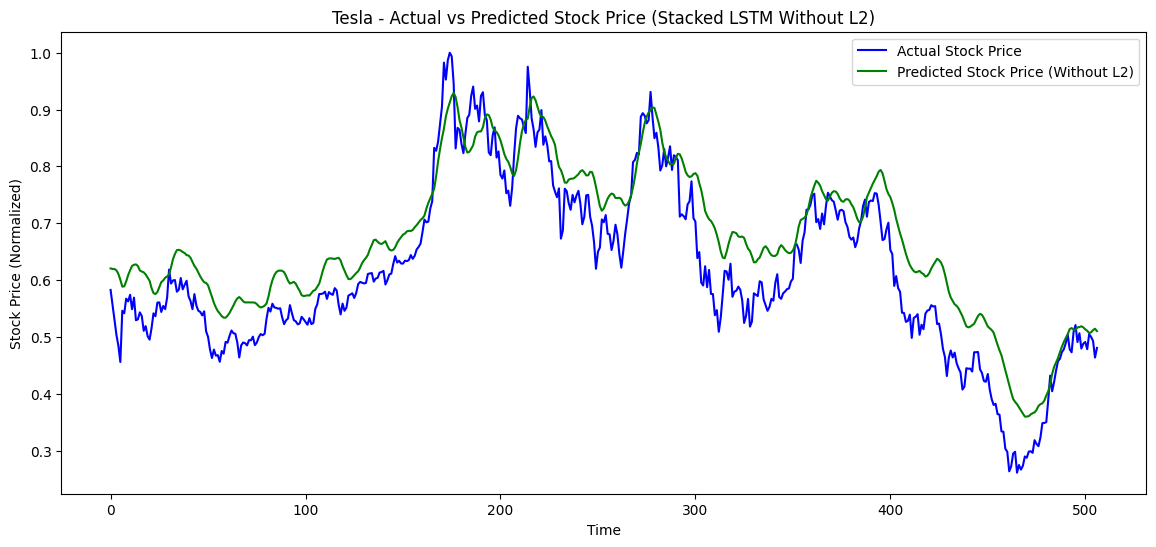

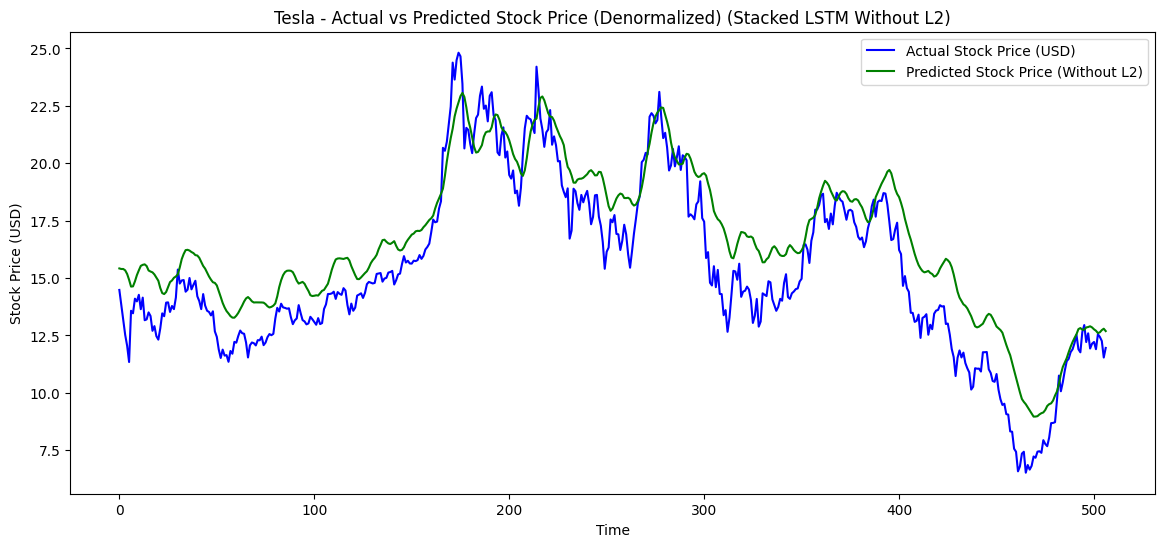

Root Mean Squared Error (RMSE) Without L2: 1.74 USD
Mean Absolute Error (MAE) Without L2: 1.50 USD
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


<ipython-input-348-ed94afebace5>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[3] = predicted_price


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


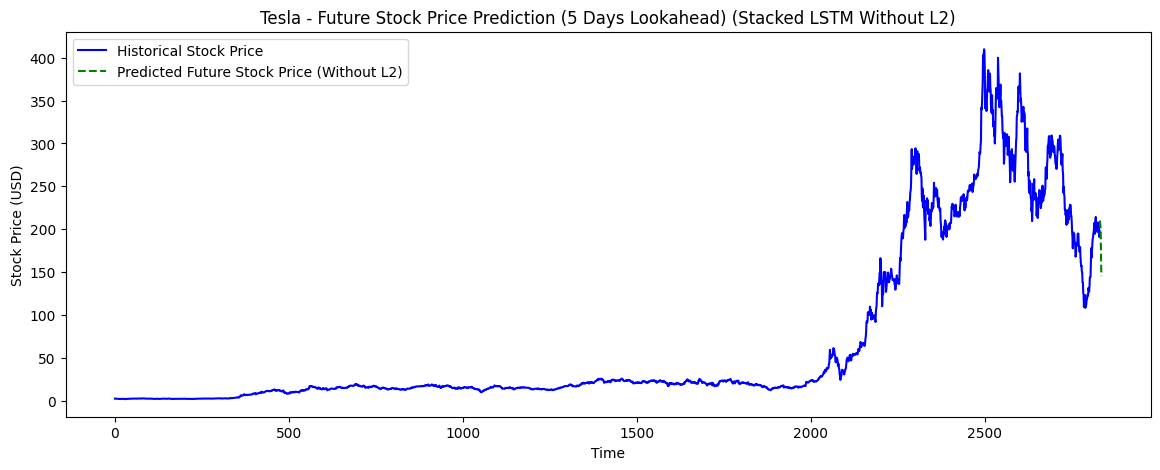

In [350]:
# Make predictions on the test dataset using stacked LSTM (without L2 regularization)
y_pred_stacked_no_l2 = model_stacked_no_l2.predict(X_test)

# Plot the actual vs predicted stock prices (normalized)
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual Stock Price', color='blue')
plt.plot(y_pred_stacked_no_l2, label='Predicted Stock Price (Without L2)', color='green')
plt.xlabel('Time')
plt.ylabel('Stock Price (Normalized)')
plt.title('Tesla - Actual vs Predicted Stock Price (Stacked LSTM Without L2)')
plt.legend()
plt.show()

# Denormalize the predictions and actual values
y_test_denorm_stacked_no_l2 = scaler.inverse_transform(
    np.concatenate((np.zeros((y_test.shape[0], scaled_data.shape[1] - 1)), y_test.reshape(-1, 1)), axis=1)
)[:, -1]
y_pred_denorm_stacked_no_l2 = scaler.inverse_transform(
    np.concatenate((np.zeros((y_pred_stacked_no_l2.shape[0], scaled_data.shape[1] - 1)), y_pred_stacked_no_l2.reshape(-1, 1)), axis=1)
)[:, -1]

# Plot the actual vs predicted stock prices (denormalized)
plt.figure(figsize=(14, 6))
plt.plot(y_test_denorm_stacked_no_l2, label='Actual Stock Price (USD)', color='blue')
plt.plot(y_pred_denorm_stacked_no_l2, label='Predicted Stock Price (Without L2)', color='green')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.title('Tesla - Actual vs Predicted Stock Price (Denormalized) (Stacked LSTM Without L2)')
plt.legend()
plt.show()

# Calculate and print RMSE and MAE for the model without L2 regularization
rmse_stacked_no_l2 = np.sqrt(mean_squared_error(y_test_denorm_stacked_no_l2, y_pred_denorm_stacked_no_l2))
mae_stacked_no_l2 = np.mean(np.abs(y_test_denorm_stacked_no_l2 - y_pred_denorm_stacked_no_l2))

print(f"Root Mean Squared Error (RMSE) Without L2: {rmse_stacked_no_l2:.2f} USD")
print(f"Mean Absolute Error (MAE) Without L2: {mae_stacked_no_l2:.2f} USD")

# Predict the future stock prices using the stabilized approach for the non-L2 model
n_days = 5  # Predict the next 5 days of stock prices
predicted_future_prices_stabilized_stacked_no_l2 = predict_future_prices_stabilized(model_stacked_no_l2, scaled_data, lookback_period, n_days)

# Plot the results for future prediction using the non-L2 model
plt.figure(figsize=(14, 5))
plt.plot(range(len(stock_data)), stock_data['Close'], color='blue', label='Historical Stock Price')
plt.plot(range(len(stock_data), len(stock_data) + n_days), predicted_future_prices_stabilized_stacked_no_l2, color='green', linestyle='--', label='Predicted Future Stock Price (Without L2)')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.title(f'Tesla - Future Stock Price Prediction ({n_days} Days Lookahead) (Stacked LSTM Without L2)')
plt.legend()
plt.show()

In [351]:
# Define L2 regularization strength
l2_strength = 0.001

# Build stacked LSTM model with L2 regularization
model_stacked = Sequential()
model_stacked.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(l2_strength)))
model_stacked.add(LSTM(50, return_sequences=False, kernel_regularizer=l2(l2_strength)))
model_stacked.add(Dropout(0.2))
model_stacked.add(Dense(1, kernel_regularizer=l2(l2_strength)))

# Compile the model
model_stacked.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_stacked = model_stacked.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=64)

# Evaluate the model
train_loss_stacked = model_stacked.evaluate(X_train, y_train, verbose=0)
test_loss_stacked = model_stacked.evaluate(X_test, y_test, verbose=0)
print(f"Stacked LSTM with L2 Regularization - Train Loss: {train_loss_stacked:.4f}, Test Loss: {test_loss_stacked:.4f}")

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1150 - val_loss: 0.1010
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0634 - val_loss: 0.0538
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - loss: 0.0390 - val_loss: 0.0374
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0252 - val_loss: 0.0279
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0174 - val_loss: 0.0235
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 0.0128 - val_loss: 0.0206
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0099 - val_loss: 0.0209
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0079 - val_loss: 0.0226
Epoch 9/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - loss: 0.0065 - val_loss: 0.0313
Epoch 10/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0055 - val_loss: 0.0422
Epoch 11/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.0046 - val_loss: 0.0510
Epoch 12/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0039 - va

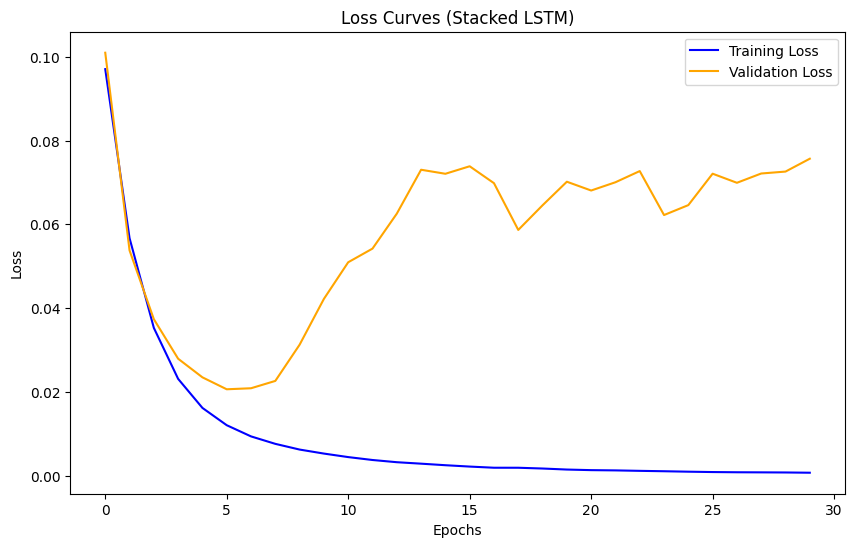

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


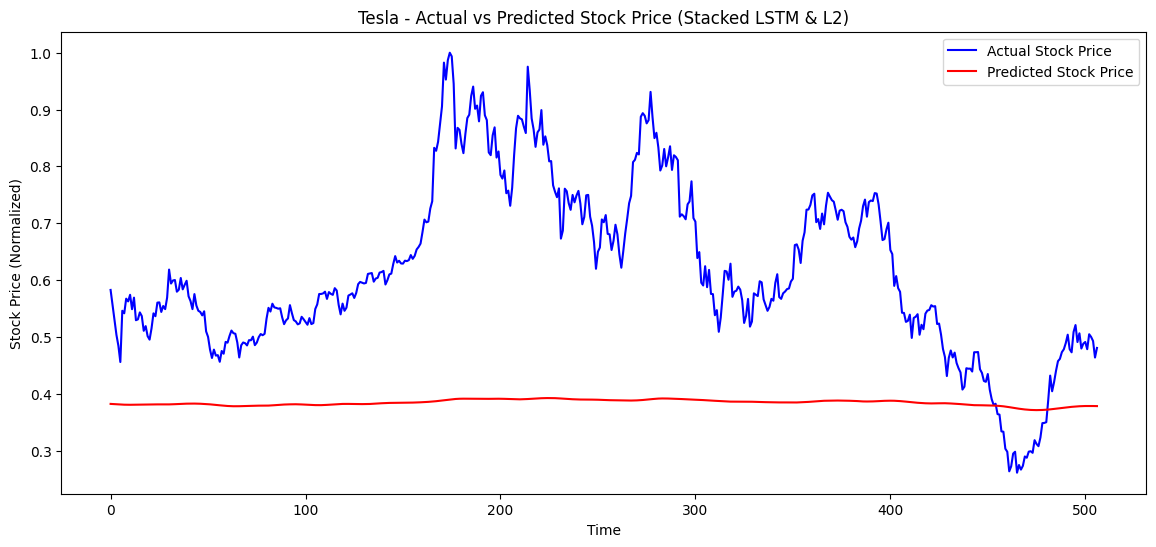

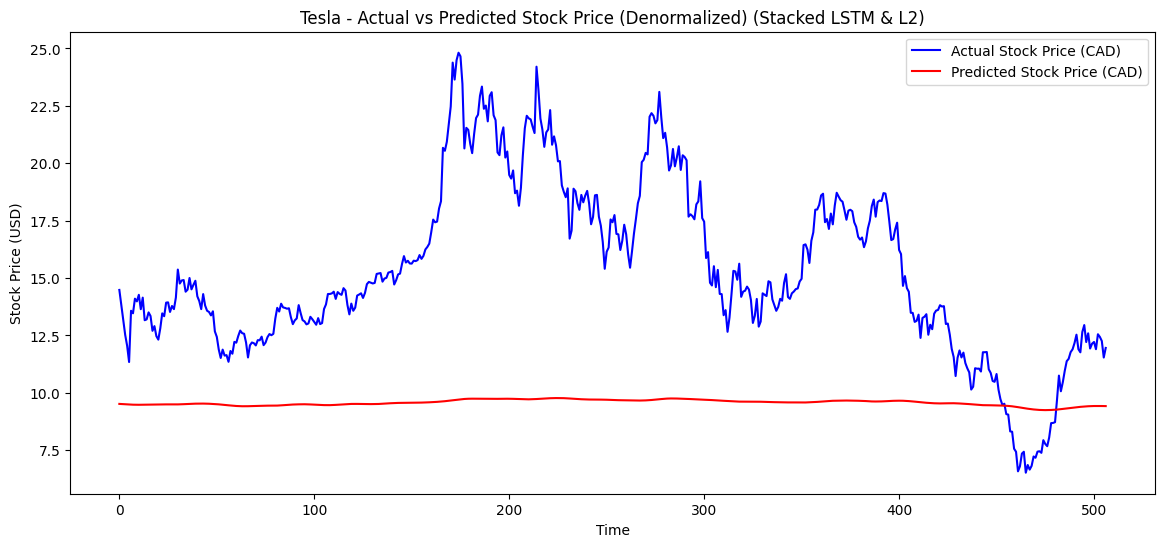

Root Mean Squared Error (RMSE): 6.79 USD
Mean Absolute Error (MAE): 5.91 USD
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


<ipython-input-348-ed94afebace5>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[3] = predicted_price


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


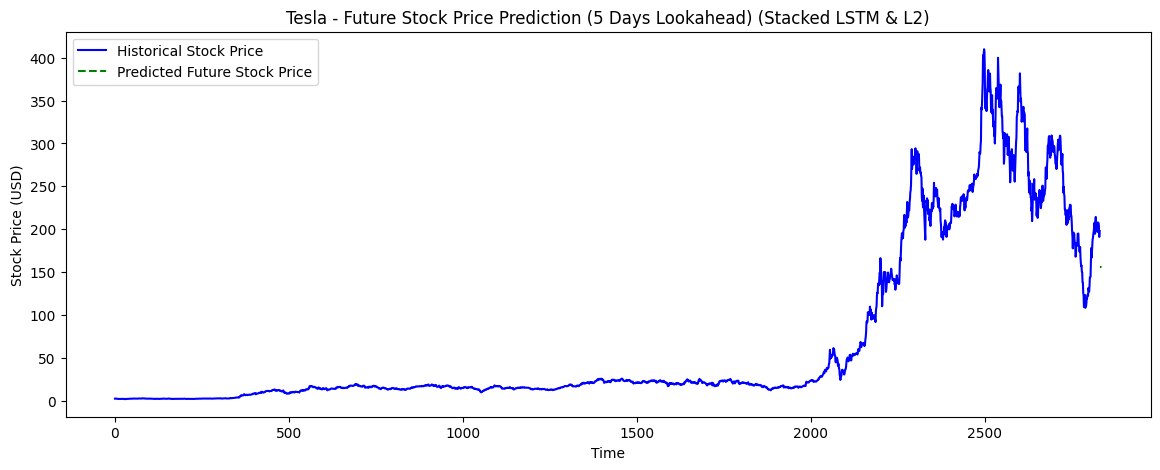

In [352]:
# Plot the training and validation loss curves for the stacked LSTM model
plt.figure(figsize=(10, 6))
plt.plot(history_stacked.history['loss'], label='Training Loss', color='blue')
plt.plot(history_stacked.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves (Stacked LSTM)')
plt.legend()
plt.show()

# Make predictions on the test dataset using stacked LSTM
y_pred_stacked = model_stacked.predict(X_test)

# Plot the actual vs predicted stock prices (normalized)
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual Stock Price', color='blue')
plt.plot(y_pred_stacked, label='Predicted Stock Price', color='red')
plt.xlabel('Time')
plt.ylabel('Stock Price (Normalized)')
plt.title('Tesla - Actual vs Predicted Stock Price (Stacked LSTM & L2)')
plt.legend()
plt.show()

# Denormalize the predictions and actual values
y_test_denorm_stacked = scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], scaled_data.shape[1] - 1)), y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_denorm_stacked = scaler.inverse_transform(np.concatenate((np.zeros((y_pred_stacked.shape[0], scaled_data.shape[1] - 1)), y_pred_stacked.reshape(-1, 1)), axis=1))[:, -1]

# Plot the actual vs predicted stock prices (denormalized)
plt.figure(figsize=(14, 6))
plt.plot(y_test_denorm_stacked, label='Actual Stock Price (CAD)', color='blue')
plt.plot(y_pred_denorm_stacked, label='Predicted Stock Price (CAD)', color='red')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.title('Tesla - Actual vs Predicted Stock Price (Denormalized) (Stacked LSTM & L2)')
plt.legend()
plt.show()

# Calculate and print RMSE and MAE for the stacked LSTM model
rmse_stacked = np.sqrt(mean_squared_error(y_test_denorm_stacked, y_pred_denorm_stacked))
mae_stacked = mean_absolute_error(y_test_denorm_stacked, y_pred_denorm_stacked)

print(f"Root Mean Squared Error (RMSE): {rmse_stacked:.2f} USD")
print(f"Mean Absolute Error (MAE): {mae_stacked:.2f} USD")

# Predict the future stock prices using the stabilized approach for stacked LSTM
n_days = 5  # Predict the next 5 days of stock prices
predicted_future_prices_stabilized_stacked = predict_future_prices_stabilized(model_stacked, scaled_data, lookback_period, n_days)

# Plot the results for future prediction using stacked LSTM
plt.figure(figsize=(14, 5))
plt.plot(range(len(stock_data)), stock_data['Close'], color='blue', label='Historical Stock Price')
plt.plot(range(len(stock_data), len(stock_data) + n_days), predicted_future_prices_stabilized_stacked, color='green', linestyle='--', label='Predicted Future Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.title(f'Tesla - Future Stock Price Prediction ({n_days} Days Lookahead) (Stacked LSTM & L2)')
plt.legend()
plt.show()

In [353]:
# Define Bidirectional LSTM Model
model_bidir = Sequential()
model_bidir.add(Bidirectional(LSTM(50, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[2])))
model_bidir.add(Dropout(0.2))
model_bidir.add(Dense(1))

# Compile the model
model_bidir.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_bidir = model_bidir.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=64)

# Evaluate the model
train_loss_bidir = model_bidir.evaluate(X_train, y_train, verbose=0)
test_loss_bidir = model_bidir.evaluate(X_test, y_test, verbose=0)
print(f"Bidirectional LSTM - Train Loss: {train_loss_bidir:.4f}, Test Loss: {test_loss_bidir:.4f}")

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0105 - val_loss: 0.0172
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0020 - val_loss: 0.0188
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0014 - val_loss: 0.0199
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 9.2021e-04 - val_loss: 0.0212
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 7.2912e-04 - val_loss: 0.0151
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 5.1254e-04 - val_loss: 0.0148
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.7000e-04 - val_loss: 0.0118
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - loss: 4.0449e-04 - val_loss: 0.0101
Epoch 9/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 3.3836e-04 - val_loss: 0.0086
Epoch 10/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.0875e-04 - val_loss: 0.0064
Epoch 11/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 3.0948e-04 - val_loss: 0.0097
Epoch 12/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s

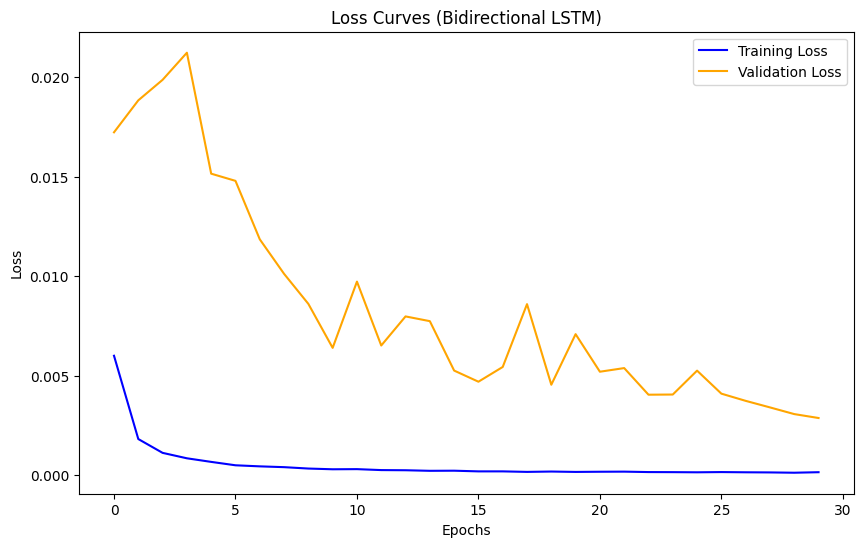

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


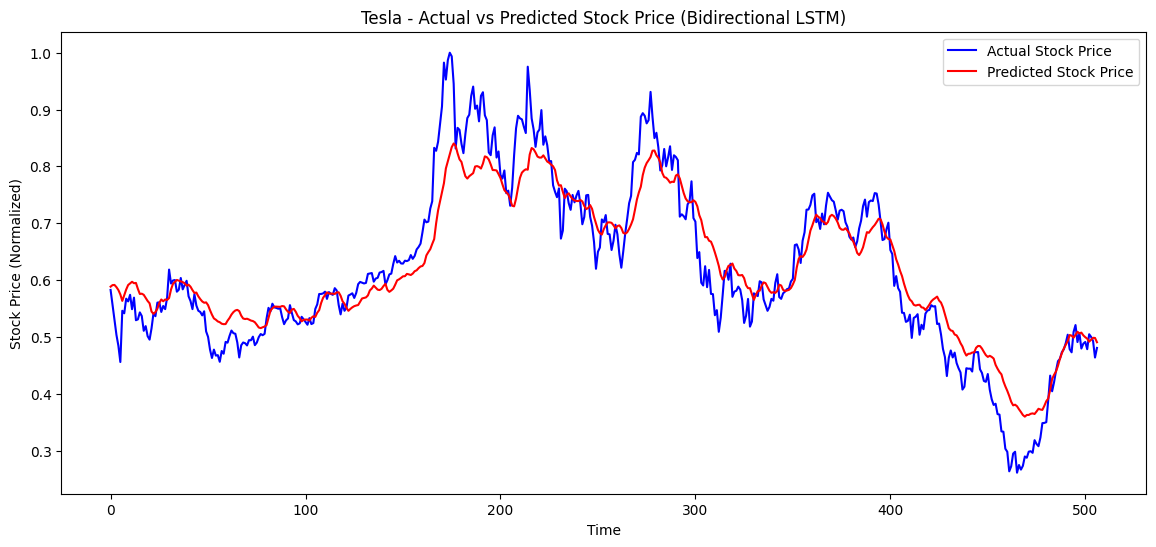

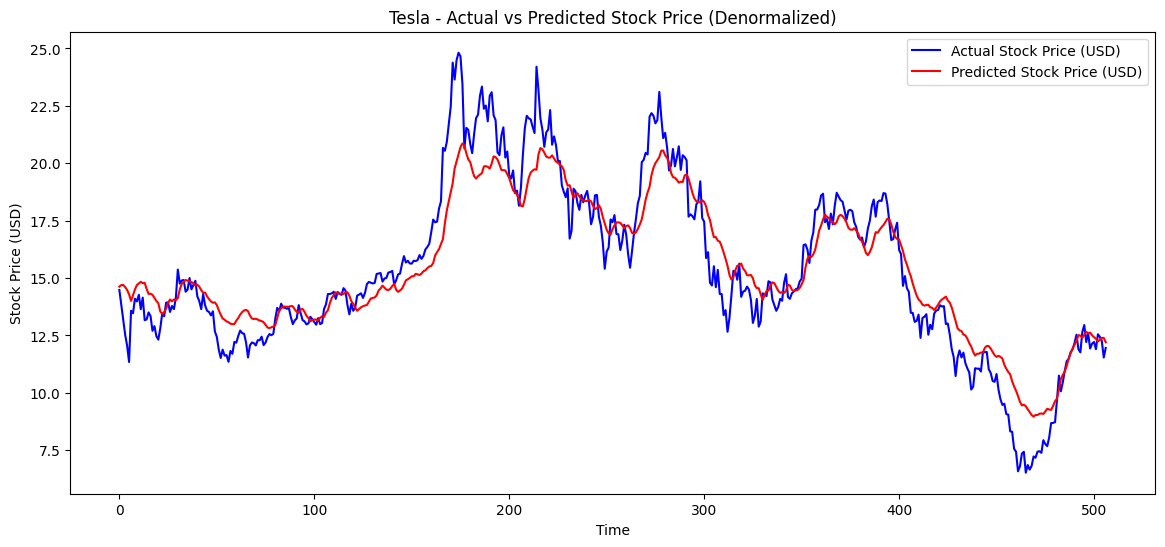

Root Mean Squared Error (RMSE): 1.32 USD
Mean Absolute Error (MAE): 1.00 USD
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


<ipython-input-348-ed94afebace5>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[3] = predicted_price


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


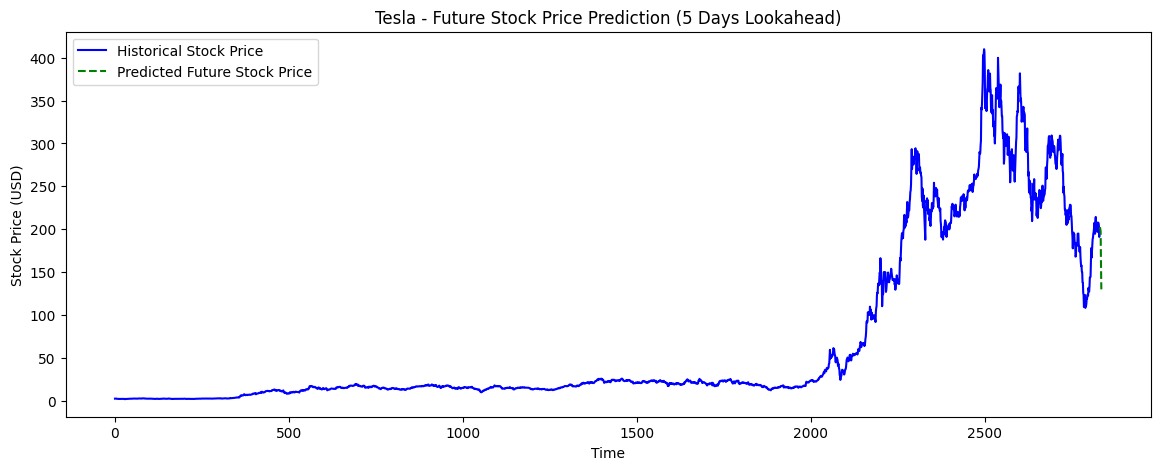

In [354]:
# Plot the training and validation loss curves for the last trained model
plt.figure(figsize=(10, 6))
plt.plot(history_bidir.history['loss'], label='Training Loss', color='blue')
plt.plot(history_bidir.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves (Bidirectional LSTM)')
plt.legend()
plt.show()

# Make predictions on the test dataset
y_pred = model_bidir.predict(X_test)

# Plot the actual vs predicted stock prices (normalized)
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual Stock Price', color='blue')
plt.plot(y_pred, label='Predicted Stock Price', color='red')
plt.xlabel('Time')
plt.ylabel('Stock Price (Normalized)')
plt.title('Tesla - Actual vs Predicted Stock Price (Bidirectional LSTM)')
plt.legend()
plt.show()

# Denormalize the predictions and actual values
y_test_denorm = scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], scaled_data.shape[1] - 1)), y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_denorm = scaler.inverse_transform(np.concatenate((np.zeros((y_pred.shape[0], scaled_data.shape[1] - 1)), y_pred.reshape(-1, 1)), axis=1))[:, -1]

# Plot the actual vs predicted stock prices (denormalized)
plt.figure(figsize=(14, 6))
plt.plot(y_test_denorm, label='Actual Stock Price (USD)', color='blue')
plt.plot(y_pred_denorm, label='Predicted Stock Price (USD)', color='red')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.title('Tesla - Actual vs Predicted Stock Price (Denormalized)')
plt.legend()
plt.show()

# Calculate and print RMSE and MAE for the model
rmse = np.sqrt(mean_squared_error(y_test_denorm, y_pred_denorm))
mae = mean_absolute_error(y_test_denorm, y_pred_denorm)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f} USD")
print(f"Mean Absolute Error (MAE): {mae:.2f} USD")

# Predict the future stock prices using the stabilized approach
n_days = 5  # Predict the next 5 days of stock prices
predicted_future_prices_stabilized = predict_future_prices_stabilized(model_bidir, scaled_data, lookback_period, n_days)

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(range(len(stock_data)), stock_data['Close'], color='blue', label='Historical Stock Price')
plt.plot(range(len(stock_data), len(stock_data) + n_days), predicted_future_prices_stabilized, color='green', linestyle='--', label='Predicted Future Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.title(f'Tesla - Future Stock Price Prediction ({n_days} Days Lookahead)')
plt.legend()
plt.show()

### Summary of Errors

- Dataset with sentiment features
| Model                                | RMSE (USD) | MAE (USD) |
|--------------------------------------|------------|-----------|
| **Single Layer LSTM**                | 1.81       | 1.40      |
| **Stacked LSTM without L2 Regularization** | 1.74       | 1.50      |
| **Stacked LSTM with L2 Regularization**    | 5.79       | 5.91      |
| **Bidirectional LSTM**               | 1.32       | 1.00      |


- Original Dataset without sentiment
| Model                                | RMSE (USD) | MAE (USD) |
|--------------------------------------|------------|-----------|
| **Single Layer LSTM**                | 0.97       | 0.74      |
| **Stacked LSTM without L2 Regularization** | 1.55       | 1.31      |
| **Stacked LSTM with L2 Regularization**    | 3.66       | 3.14      |
| **Bidirectional LSTM**               | 1.87       | 1.54      |

Although Bidirectional LSTM is the best model in after the sentiment integration, but compared with the best model without sentiment analysis: Single Layer LSTM, adding the sentiment features has higher errors than the data without sentiment analysis.   

### Key Findings: 

- Lack of Correlation: There was no strong correlation between Musk's tweet sentiments and Tesla's stock prices. This suggests that external market factors or broader economic indicators may play a more significant role. 
- Challenges in Sentiment Analysis: 
   - The sentiment data might not adequately impact the financial market reactions. 
   - The reliance on a single daily tweet to represent sentiment may oversimplify the complex dynamics influencing stock prices. 

### Conclusion: 

While the integration of sentiment analysis added a new dimension to the model, the results demonstrated that Musk's tweets have limited predictive value for Tesla's stock price. This suggests that external factors or other variables might play a more dominant role in driving share price movements, rendering the data less relevant for predictive modeling in this context. 